## This notebook encompasses a storyline & real-world use-case for the company I work in...
**Background Information**
- Company X collects web-scrapped text data (from business websites) for business statistical studies (eg. generation of new statistical indicators).
- Company Y wants to study the Innovative Landscape of Singapore - I.e. The identification & scope of Innovative Firms.
- ***Inserts Definition Table for Innovative Firms (Product vs Process Innovation)***
- Company X suggests to build a predictive model to return (1) Predictions (0,1) & (2) Predictive Probabilities for Innovative Firm Identification based on website text data collected. A collaboration is brewing...

**Process Flow**
1. Summarizing (to form X) web-text data to a suitable format to be used for Innovative Firm Identification (LLM-based)
2. Baseline RUN - Using baseline LLM to run & return (1) Predictions (2) Predicted probabilities
3. Using LORA to fine-tune LLM model
4. Running the fine-tuned LLM model & capture evaluation metrics (experimentation)

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df_path = '/content/drive/MyDrive/Colab Notebooks/datasets/web_text_innov020824.csv'
data = pd.read_csv(df_path)

Mounted at /content/drive


In [2]:
data.head()

,index,text,innovative_label,word_count
0,192,Expert Web Development and Digital Marketing i...,0,296
1,3690,Home Oon Bazul Skip to content Search for Home...,0,1374
2,3356,Our Latest Projects Twenty20 Energy Home About...,0,1093
3,2009,Literature Library Literature Library InVivos ...,0,444
4,1514,Aviation Unitech About Unitech Our Story Certi...,0,248


In [3]:
data["innovative_label"].value_counts()

,count
innovative_label,
0,1000
1,1000


### Run histogram to review distribution of word counts

<Axes: >

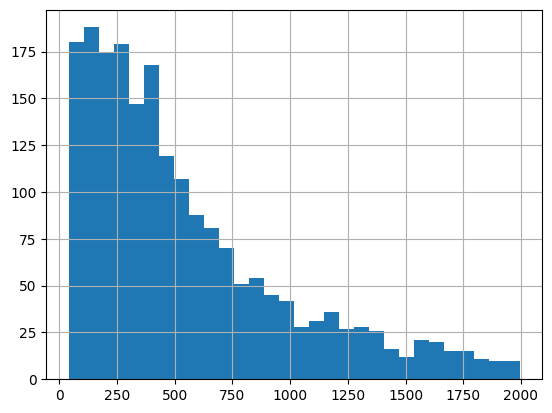

In [4]:
data["word_count"].hist(bins=30)

### Bin word counts & review short, medium & long text

In [5]:
def bin_word_counts(data):
    """
    Bins the 'word_counts' column into 3 classes:
    1-500: "Short text"
    501-1000: "Medium text"
    >1000: "Long text"

    Parameters:
    data (pd.DataFrame): The input DataFrame containing a 'word_counts' column.

    Returns:
    pd.DataFrame: DataFrame with an additional column 'text_class' for the binned classes.
    """

    # Define the binning function
    def classify_word_count(count):
        if count <= 500:
            return "Short text"
        elif 500 < count <= 1000:
            return "Medium text"
        else:
            return "Long text"

    # Apply the binning function to the 'word_counts' column
    data['text_class'] = data['word_count'].apply(classify_word_count)

    return data

In [6]:
data = bin_word_counts(data)
data.head()

,index,text,innovative_label,word_count,text_class
0,192,Expert Web Development and Digital Marketing i...,0,296,Short text
1,3690,Home Oon Bazul Skip to content Search for Home...,0,1374,Long text
2,3356,Our Latest Projects Twenty20 Energy Home About...,0,1093,Long text
3,2009,Literature Library Literature Library InVivos ...,0,444,Short text
4,1514,Aviation Unitech About Unitech Our Story Certi...,0,248,Short text


In [7]:
import pandas as pd

def sample(data, n=1):
    """
    Returns a random sample from each class of 'text_class'.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing a 'text_class' column.
    n (int): The number of samples to return from each class. Default is 1.

    Returns:
    pd.DataFrame: DataFrame containing the sampled rows.
    """

    # Group by 'text_class' and sample 'n' rows from each group
    sampled_data = data.groupby('text_class').apply(lambda x: x.sample(n=min(n, len(x)))).reset_index(drop=True)

    # Print the sampled data in a readable format
    for _, row in sampled_data.iterrows():
        print(f"Class: {row['text_class']}")
        print(f"Word Count: {row['word_count']}")
        print(f"Data: {row.to_dict()}")
        print("-" * 40)

    return sampled_data

In [8]:
sample(data)

Class: Long text
Word Count: 1854
Data: {'index': 1687, 'text': "Real Time PCR Assays Thermo Fisher Scientific SG Hamburger Menu Button Thermo Fisher Scientific Logo Sign in Don't have an account Create Account Products Antibodies Cell Culture Media Chemicals Western Blot Products Chromatography Columns and Cartridges Lab Equipment Lab Plasticware and Supplies Microplates Oligos, Primers, Probes and Genes TaqMan Real Time PCR Assays Greener Products See all product categories Applications Bioprocessing Cell Culture and Transfection Food and Beverage Lab Solutions Pharma and Biopharma Real Time PCR Semiconductor Analysis Clinical and Diagnostics Digital Solutions Spectroscopy, Elemental and Isotope Analysis See all applications and techniques Services CDMO and Clinical Trial Services Custom Services Enterprise Services Financial and Leasing Services Instrument Services Lab Informatics OEM and Commercial Supply Training Services See all services Help and Support Order Help Digital Soluti

,index,text,innovative_label,word_count,text_class
0,1687,Real Time PCR Assays Thermo Fisher Scientific ...,0,1854,Long text
1,2575,Exploitez toutes les donnes de votre projet de...,1,611,Medium text
2,1598,Hammer Koh Khang Hin top of pageabout us Conta...,1,250,Short text


#### Findings: Text data incoherent. Craft a good prompt for summarization which includes components:
- Summarizer & Business website analyzer persona
- Task: Identify and capture keywords or sentences relating to "Innovation status" of firm. List words in coherent form (consider options)
- Context: Identify firms that are innovative in practices (eg. conduct R&D, perform product or process innovation)
- Example: ...
- Format: ...

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

_new_max_tokens = 32 if not torch.cuda.is_available() else 160

# If you are using Apple M1, M2, M3 on your local machine
if not torch.cuda.is_available() and torch.backends.mps.is_available():
  if torch.backends.mps.is_built():
      device = "mpu"

In [10]:
# you can also try, using GPU is hightly recommended
model_name = "microsoft/Phi-3-mini-4k-instruct"
# model_name = "Qwen/Qwen1.5-0.5B-Chat"

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto").to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def complete(messages, max_new_tokens=_new_max_tokens):

  # we first want to convert our messages to text
  text = tokenizer.apply_chat_template(
      messages,
      tokenize=False,
      add_generation_prompt=True
  )

  inputs = tokenizer(text, return_tensors="pt").to(device)

  outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id)

  generated_ids = outputs[0][len(inputs.input_ids[0]):]

  return text, tokenizer.decode(generated_ids, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
# test dataset
def extract_long(data, n=10):

    # Filter the DataFrame to only include 'Long text' class
    long_texts = data[data['text_class'] == 'Long text']

    # Sample 'n' rows from the 'Long text' class
    test_set = long_texts.sample(n=min(n, len(long_texts))).reset_index(drop=True)

    return test_set

In [12]:
test = extract_long(data)
test

,index,text,innovative_label,word_count,text_class
0,1346,Pinnacle Duxton Visit Singapore Official Site ...,1,1024,Long text
1,484,aircargo tracking aircargotracking.net aircarg...,0,1589,Long text
2,1984,Green Home with Senoko Senoko Energy Your Cybe...,1,1281,Long text
3,1101,Produkty Accu Chek dedykowane do codziennej sa...,0,1175,Long text
4,3372,Poseidon AI top of pageThis site was designed ...,1,1239,Long text
5,1506,Careers About Us Overview Our Purpose Our Valu...,1,1387,Long text
6,3421,Walraven South Africa South Africa Downloads P...,1,1283,Long text
7,2400,Careers Guthrie Engineering About UsOur Servic...,0,1095,Long text
8,241,Code of Conduct Directa Cookies This website u...,0,1616,Long text
9,1085,"Sucuri Complete Website Security, Protection M...",0,1417,Long text


In [13]:
label_1_sample = test[test['innovative_label'] == 1].sample(n=1)
label_0_sample = test[test['innovative_label'] == 0].sample(n=1)

test1 = pd.concat([label_1_sample, label_0_sample]).reset_index(drop=True)

test1

,index,text,innovative_label,word_count,text_class
0,1984,Green Home with Senoko Senoko Energy Your Cybe...,1,1281,Long text
1,241,Code of Conduct Directa Cookies This website u...,0,1616,Long text


In [14]:
test1.iloc[1]

index                                                             241
text                Code of Conduct Directa Cookies This website u...
innovative_label                                                    0
word_count                                                       1616
text_class                                                  Long text
Name: 1, dtype: object

In [15]:
# TEST Summary Function  - Prompt-tuning
from tqdm.notebook import tqdm

for text in tqdm(test1["text"]):

  # modify the prompt to pass the evaluation
  messages = [
      {"role": "user", "content": f"Act as an expert in the field of web-text data from business websites. \
                                    Task: To identify and capture keywords in website text related to product and process innovation activities in businesses. \
                                    Output format: List words in one continuous sentence with one whitespace in between. \
                                    Constraints: Do not list words that are not in English dictionary. List only words in the website. \
                                    website text data: {text}"}
  ]
  _, completion = complete(messages)
  print("OUTPUT:")
  print()
  print(completion)
  print("-" * 100)

print("=" * 100)
print()

  0%|          | 0/2 [00:00<?, ?it/s]

You are not running the flash-attention implementation, expect numerical differences.


OUTPUT:

Green Home, Smart Solutions, EcoSmart Homes, Electric Vehicle Solutions, Home Solar Solutions, Solar power, electric vehicle, solar panels, EV charging system, EV charging point, EV charging system installation, EV charging infrastructure, EV charging safety, EV charging standards, Technical Reference TR 25, AC chargers, DC chargers, EV charging speed, Kilowatt kW rating, Licensed Electrical Worker LEW, EV charging system maintenance, Senoko Energy, electricity plans, Smarter Savings, Energy Plans, Energy Management, Sustainable Energy Solutions, Energy Partnership Support, TakeCharge Comm
----------------------------------------------------------------------------------------------------
OUTPUT:

The content.

 Information.

 Information.

 The following.

 Information.



 The following.



 The information.





offering.
 Information.





urea.
 You.

  11.




  
  
  

  
  





  1.
  


offering.



                                 

   
: The following: The followin

### Function to return summarized text in data

In [16]:
data["text_class"].value_counts()

,count
text_class,
Short text,1160
Medium text,526
Long text,314


In [17]:
# Sample 100 records (balanced) from data. Sample only long text.
df = data.copy()

label_1_sample = df.loc[(df['innovative_label'] == 1) & (df['text_class'] == 'Long text')].sample(n=50)
label_0_sample = df.loc[(df['innovative_label'] == 0) & (df['text_class'] == 'Long text')].sample(n=50)

data = pd.concat([label_1_sample, label_0_sample]).reset_index(drop=True)

In [18]:
from tqdm.notebook import tqdm
def add_summary(data, batch_size=5):

    text_summaries = []
    for start in tqdm(range(0, len(data), batch_size)):
        end = start + batch_size
        batch_texts = data["text"][start:end]

        for text in batch_texts:
            messages = [
                {"role": "user", "content": f"Act as an expert in the field of web-text data from business websites. \
                                              Task: To identify and capture keywords in website text related to product and process innovation activities in businesses. \
                                              Output format: List words in one continuous sentence with one whitespace in between. \
                                              Constraints: Do not list words that are not in English dictionary. List only words in the website. \
                                              website text data: {text}"}
            ]
            _, completion = complete(messages)
            text_summaries.append(completion)

        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    data["text_summary"] = text_summaries

    return data

In [19]:
data = add_summary(data)

  0%|          | 0/20 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4282 > 4096). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


In [20]:
data.head()

,index,text,innovative_label,word_count,text_class,text_summary
0,2209,About Fraunhofer Singapore Search Academy Trai...,1,1745,Long text,The data.\n\n\n\n The data.\n\n\n\n\n ...
1,1893,Blackmagic Design Products Resellers Support D...,1,1630,Long text,"10 AI, Australia, Australia, 120, 16, \nand ..."
2,3520,Bunkerspot catches up with Dr Prapisala Thepsi...,1,1972,Long text,"The \n of the \n The data, \..."
3,3077,Baumller's Drive and Automation Systems Skip t...,1,1333,Long text,Company.\n\n Business in the company.\n\nsales...
4,1982,Corporate governance Symrise Welcome to Symris...,1,1375,Long text,"Innovation, circular economy, sustainability, ..."


In [21]:
# data.to_csv('/content/drive/MyDrive/Colab Notebooks/datasets/web_text_summary050824.csv', index=False)

## Parameter Efficient Fine-Tuning VS Baseline Model Predictions
***Analyze LoRA PEFT method vs baseline scores on Innovative Firm Classification use-case***
- LoRA article for reference: https://medium.com/aimonks/parameter-efficient-fine-tuning-075954d1db51

In [1]:
!pip install peft --no-deps
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    

In [48]:
# import dataset
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/web_text_summary050824.csv')
data = data[["text_summary", "innovative_label"]].rename(columns={"text_summary":"text", "innovative_label":"label"})
data.head()

,text,label
0,The data.\n\n\n\n The data.\n\n\n\n\n ...,1
1,"10 AI, Australia, Australia, 120, 16, \nand ...",1
2,"The \n of the \n The data, \...",1
3,Company.\n\n Business in the company.\n\nsales...,1
4,"Innovation, circular economy, sustainability, ...",1


In [49]:
data['label'].value_counts()

label
1    50
0    50
Name: count, dtype: int64

### Review Text Summaries
- Are these summaries in the correct format?
- How accurate and coherent are the summaries?

In [50]:
def word_count(data):
    # Ensure the input is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame")

    # Check if 'text_summary' column exists
    if 'text' not in data.columns:
        raise KeyError("'text_summary' column is not present in the DataFrame")

    # Function to count words in a single text
    def count_words(text):
        if pd.isna(text):  # Handle NaN values
            return 0
        return len(text.split())

    # Apply the word count function to the 'text_summary' column
    data['word_count'] = data['text'].apply(count_words)

    return data

<Axes: >

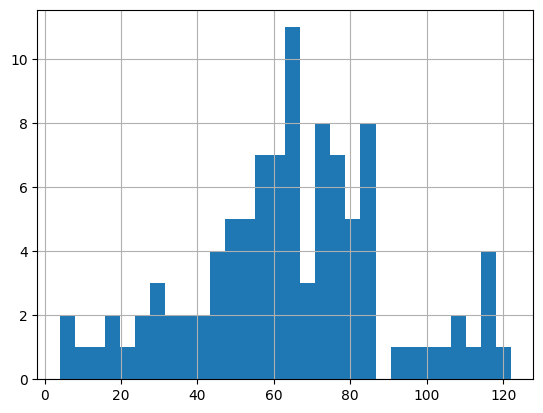

In [51]:
# plot hist
hist = word_count(data)
hist["word_count"].hist(bins=30)

In [52]:
# sample & print one sample with pos & one with neg label
label_1_sample = data.loc[(data['label'] == 1)].sample(n=5)
label_0_sample = data.loc[(data['label'] == 0)].sample(n=5)

testing = pd.concat([label_1_sample, label_0_sample]).reset_index(drop=True)

In [53]:
def print_text_column(dataset):

    # Iterate over the DataFrame rows and print 'text' and 'label' columns
    for index, row in dataset.iterrows():
        print(f"Text: {row['text']}, Label: {row['label']}")
        print('-'*500)
print_text_column(testing)

Text: ASTAR, ASTAR International Fellowship, ASTAR Scholarships, ASTAR Research Internship Award, ASTAR National Science Scholarship, ASTAR Masters National Science Scholarship, ASTAR PhD Scholarship, ASTAR Computing Information Science Scholarship, ASTAR Graduate Scholarship, ASTAR Singapore International Graduate Award, ASTAR MOE Attachment Research Attachments, ASTAR RIs, ASTAR Scholars, ASTAR Science Award, ASTAR Junior College, Polytechnic and Secondary School Students, ASTAR Research Attachment Programme, ASTAR MOE Attachment Research Attachments, ASTAR Scholarship Award, Label: 1
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### "TEXT" data needs to be further processed to:
1. Remove extra white spaces
2. Combine words into a continuous sentence
3. Remove meaningless or mis-spelled words
***To further improve downstream classification tasks***

In [54]:
pip install nltk pyspellchecker

In [56]:
import pandas as pd
from nltk.corpus import stopwords
from spellchecker import SpellChecker
import nltk
import random

# Download stopwords from NLTK
nltk.download('stopwords')

def process_text(dataset):
    # Ensure the input is a pandas DataFrame
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame")

    # Check if 'text' column exists
    if 'text' not in dataset.columns:
        raise KeyError("'text' column is not present in the DataFrame")

    # Initialize spell checker and stop words list
    spell = SpellChecker()
    stop_words = set(stopwords.words('english'))

    def process_sentence(text):
        # Remove extra white spaces and combine all words into one sentence
        text = ' '.join(text.split())

        # Split text into words
        words = text.split()

        # Remove meaningless or misspelled words
        processed_words = [
            word for word in words
            if word.lower() not in stop_words and spell.candidates(word)
        ]

        # Join processed words into a continuous sentence
        return ' '.join(processed_words)

    # Apply the text processing function to the 'text' column
    dataset['processed_text'] = dataset['text'].apply(process_sentence)

    # Print 3 random sentences from the processed data
    sample_indices = random.sample(range(len(dataset)), min(3, len(dataset)))
    for idx in sample_indices:
        print(f"Original Text: {dataset.at[idx, 'text']}")
        print(f"Processed Text: {dataset.at[idx, 'processed_text']}")
        print("-" * 50)

    return dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
df = process_text(data)

Original Text: DZH International, DZHI Trader, DZHI Advisor Trader, DZHI ODiN, DZHI White Label, DZHI Advisor Xs, DZHI Financial Info Terminals, DZHI Trader, DZHI Advisor Trader, DZHI Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZ
Processed Text: DZH International, DZHI Trader, DZHI Advisor Trader, DZHI ODiN, DZHI White Label, DZHI Advisor Xs, DZHI Financial Info Terminals, DZHI Trader, DZHI Advisor Trader, DZHI Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZHI Advisor Trader, DZ
--------------------------------------------------
Original Text: 20 20 
                   A 20ve between the 
                   Avoid: 
        

In [58]:
df.head()

,text,label,word_count,processed_text
0,The data.\n\n\n\n The data.\n\n\n\n\n ...,1,28,"data. data. following. data. data. data, follo..."
1,"10 AI, Australia, Australia, 120, 16, \nand ...",1,32,"10 AI, Australia, Australia, - AI 10 3and AI -..."
2,"The \n of the \n The data, \...",1,86,"data, , following following, following, follow..."
3,Company.\n\n Business in the company.\n\nsales...,1,97,Company. Business company. sales. Company. Com...
4,"Innovation, circular economy, sustainability, ...",1,46,"Innovation, circular economy, sustainability, ..."


In [61]:
data = df[["processed_text", "label"]].rename(columns={"processed_text":"text"})
data.head()

,text,label
0,"data. data. following. data. data. data, follo...",1
1,"10 AI, Australia, Australia, - AI 10 3and AI -...",1
2,"data, , following following, following, follow...",1
3,Company. Business company. sales. Company. Com...,1
4,"Innovation, circular economy, sustainability, ...",1


In [62]:
# prepare train & test datasets
import pandas as pd
from sklearn.model_selection import train_test_split

def balanced_train_test_split(data, label_column, test_size=0.3):

    # Separate the dataset into two DataFrames based on the label
    class_0 = data[data[label_column] == 0]
    class_1 = data[data[label_column] == 1]

    # Split each class into train and test sets
    train_0, test_0 = train_test_split(class_0, test_size=test_size, random_state=42)
    train_1, test_1 = train_test_split(class_1, test_size=test_size, random_state=42)

    # Combine the train sets and test sets from both classes
    train = pd.concat([train_0, train_1]).sample(frac=1).reset_index(drop=True)
    test = pd.concat([test_0, test_1]).sample(frac=1).reset_index(drop=True)

    return train, test

In [63]:
train, test = balanced_train_test_split(data, "label", test_size=0.3)

In [64]:
test.head()

,text,label
0,"SAP 4HANA, AI Capabilities, Generative AI, SAP...",1
1,"Keppel Global asset manager, sustainable futur...",0
2,Data 10 first avoid first 2 first the0 first f...,1
3,"NI, Kins, Data, Data, N data N A, Nive sentenc...",1
4,data. data. end. data. way. following. data. T...,1


In [65]:
pip install --upgrade pyarrow

In [66]:
# convert to correct format:
import pandas as pd
from datasets import Dataset
training_dataset = dataset = Dataset.from_pandas(train)
testing_dataset = dataset = Dataset.from_pandas(test)

In [67]:
print(testing_dataset.features)

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


In [74]:
# Apply conversion to generate ClassLabel().
from datasets import Dataset, Features, Value, ClassLabel

def convert_labels(dataset):
    # Define the new feature schema with ClassLabel
    new_features = Features({
        'text': Value(dtype='string'),
        'label': ClassLabel(names=['neg', 'pos'])
    })

    # Cast the dataset to the new schema
    dataset = dataset.cast(new_features)

    return dataset

In [75]:
testing_dataset = convert_labels(testing_dataset)
training_dataset = convert_labels(training_dataset)

Casting the dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/70 [00:00<?, ? examples/s]

In [76]:
print(testing_dataset.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [77]:
import torch
import random
import numpy as np

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", attn_implementation="eager", device_map="auto")

model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_head): Linear(in_features=8

In [78]:
import pandas as pd
import copy
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, messages):

    num_correct = 0

    for datum in tqdm(testing_dataset):
        text = datum["text"]
        label = "NEGATIVE" if datum["label"] == 0 else "POSITIVE"

        populated_messages = copy.deepcopy(messages)
        for msg in populated_messages:
            msg["content"] = msg["content"].replace("{SOURCE}", text)

        inputs = tokenizer.apply_chat_template(populated_messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to(model.device)
        outputs = model.generate(inputs, max_new_tokens=8, do_sample=False, top_k=None, top_p=None, temperature=None)
        output_text = tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)

        if output_text.strip() == label:
            num_correct += 1

    accuracy = num_correct / len(testing_dataset)
    print(f"ACCURACY = {accuracy:.4f}")

In [79]:
my_prompt = [{"role": "user", "content": "Classify into POSITIVE or NEGATIVE: {SOURCE}"}]

In [80]:
evaluate(model, my_prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


ACCURACY = 0.2000


#### Initialize PEFT model (LoRA)
*This model will be used to adapt the pre-trained model with fewer parameters, making the fine-tuning process more efficient.*

In [81]:
from peft import LoraConfig, TaskType, get_peft_model
from pprint import pp

# Define PEFT adapter configuration
adapter_config = LoraConfig(init_lora_weights="gaussian", r=16, use_rslora=True, task_type=TaskType.CAUSAL_LM, target_modules=["qkv_proj", "o_proj", "gate_up_proj", "down_proj"])

pp(adapter_config)

print()
print()

lora_model = get_peft_model(model, adapter_config)
lora_model.print_trainable_parameters()

print()
print()

lora_model

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>,
           auto_mapping=None,
           base_model_name_or_path=None,
           revision=None,
           task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>,
           inference_mode=False,
           r=16,
           target_modules={'down_proj', 'o_proj', 'gate_up_proj', 'qkv_proj'},
           lora_alpha=8,
           lora_dropout=0.0,
           fan_in_fan_out=False,
           bias='none',
           use_rslora=True,
           modules_to_save=None,
           init_lora_weights='gaussian',
           layers_to_transform=None,
           layers_pattern=None,
           rank_pattern={},
           alpha_pattern={},
           megatron_config=None,
           megatron_core='megatron.core',
           loftq_config={},
           use_dora=False,
           layer_replication=None,
           runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))


trainable params: 2,899,968 || all params: 496,932,736 || trainable%: 0.5836




PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): Linear(in_features=896, out_features=896, bias=True)
              (k_proj): Linear(in_features=896, out_features=128, bias=True)
              (v_proj): Linear(in_features=896, out_features=128, bias=True)
              (o_proj): lora.Linear(
                (base_layer): Linear(in_features=896, out_features=896, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=896, bias=False)
                )
   

In [82]:
# Import necessary libraries
import copy

# Define the prepare function
def prepare(data, messages):
    """
    Prepares the dataset for training by populating message templates with data,
    tokenizing the text, and creating input tensors.

    Args:
    - data: List of dictionaries, where each dictionary contains 'text' and 'label' keys.
    - messages: List of message templates to be populated with data.

    Returns:
    - output_dataset: List of dictionaries containing tokenized inputs and attention masks.
    """
    output_dataset = []  # Initialize an empty list to store the prepared data

    # Iterate through each datum in the dataset
    for datum in data:
        text = datum["text"]  # Extract the text from the datum
        label = "NEGATIVE" if datum["label"] == 0 else "POSITIVE"  # Convert numerical label to string

        # Deep copy the message templates to avoid modifying the original
        populated = copy.deepcopy(messages)

        # Populate the message templates with the text from the datum
        for msg in populated:
            msg["content"] = msg["content"].replace("{SOURCE}", text)

        # Append the label as the assistant's response to the populated messages
        populated.append({"role": "assistant", "content": label})

        # Apply chat template to the populated messages without tokenizing
        prepared_instance = tokenizer.apply_chat_template(populated, tokenize=False)

        # Tokenize the prepared instance with padding and truncation
        tokenized_instance = tokenizer(prepared_instance, return_tensors="pt")

        # Append the tokenized inputs and attention mask to the output dataset
        output_dataset.append({
            "input_ids": tokenized_instance["input_ids"][0],
            "attention_mask": tokenized_instance["attention_mask"][0],
            "labels": tokenized_instance["input_ids"][0].clone()  # Clone the input_ids to use as labels
        })

    return output_dataset  # Return the prepared dataset

# Example usage of the prepare function
tokenized_training_dataset = prepare(training_dataset, my_prompt)

# Decode the first set of input_ids to verify the tokenization
print(tokenizer.decode(tokenized_training_dataset[0]["input_ids"]))

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Classify into POSITIVE or NEGATIVE: Group. Rights Reserved. Website Accessibility Terms Use PDPARate Vulnerability Find Doctor Conditions Treatments Home Appointment E Services Group. Rights Reserved. Website Accessibility Terms Use PDPARate Vulnerability Find Doctor Conditions Treatments Home Appointment E Services Group. Rights Reserved. Website Accessibility Terms Use PDPARate Website Report Vulnerability Find Doctor Conditions Treatments Home Appointment E Services Group. Rights Responsible forensy. Website Accessibility Terms Use PDPARate Website<|im_end|>
<|im_start|>assistant
NEGATIVE<|im_end|>



In [83]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    warmup_steps=50,
    weight_decay=0.1,
    max_steps=300,
    per_device_train_batch_size=1,
    logging_steps=20,
    do_eval=False,
    bf16=True,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_training_dataset,
)

# Fine-tune the model with PEFT
trainer.train()

max_steps is given, it will override any value given in num_train_epochs
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Step,Training Loss
20,3.469700
40,2.800200
60,2.609800
80,2.262800
100,2.480600
120,2.510300
140,2.362500
160,2.037700
180,2.161900
200,2.078500


TrainOutput(global_step=300, training_loss=2.3589591471354168, metrics={'train_runtime': 40.1314, 'train_samples_per_second': 7.475, 'train_steps_per_second': 7.475, 'total_flos': 71100312837120.0, 'train_loss': 2.3589591471354168, 'epoch': 4.285714285714286})

In [84]:
evaluate(lora_model, my_prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

ACCURACY = 0.5000


Let's merge the LoRA weights into the main model and test if it works as expected. Note the overall inference time and compare it with LoRA model.

In [85]:
trained_model = lora_model.merge_and_unload()
trained_model

evaluate(trained_model, my_prompt)

  0%|          | 0/30 [00:00<?, ?it/s]

ACCURACY = 0.5000


## Conclusions & Future Work
- Applying PEFT (LoRA) by training on the small training dataset yields an improvement in accuracy score of 30% (from 20% to 50%) on the test dataset
- However, an accuracy of 50% is definitely not an acceptable metric for productionisation.
- Future works would include (not exclusive):
1. Training on a larger dataset & testing across a larger test dataset
2. Prompt engineering (fine-tuning prompts)
3. Validating web-text data & improving the quality of train & test data.
4. Etc.